## SimpleITK Tutorial 
## Tutorial on how to open, visualize and extract some features from a .mhd Image

This Tutorial will show how to:
    - Open and read a .mhd image
    - Visualize a .mhd image
    - Read a list of candidates from a .csv file
    - Transform from world coordinates to voxel coordinates
    - Extract some features / patches of candidates and visualize them
To be able to run this tutorial some python libraries / modules need to be installed:
    - Simple ITK: a library for handling and processing medical images
    - Numpy: a fundamental package for scientific computing with Python
    - PIL (Python Imaging Library): a library for adding image processing capabilities to your Python interpreter 
    - Matplotlib: a plotting library for the Python programming language
    
References
    - https://www.slicer.org/wiki/Coordinate_systems

We start importing required modules / libraries  using the import command from python

In [10]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

We define now a function to:
    - Open the image 
    - Store it into a numpy array
    - Extract the following info: Pixel Spacing, Origin
This function takes as input the name of the image and returns:
    - The array corresponding to the image (numpyImage)
    - Origin (numpyOrigin)
    - PixelSpacing (numpySpacing)

- The world coordinate system is typically a Cartesian coordinate system in which a model (e.g. a MRI scanner or a patient) is positioned. Every model has its own coordinate system but there is only one world coordinate system to define the position and orientation of each model.
- The origin represents the position of the first voxel (0,0,0) in the anatomical coordinate system, e.g. (100mm, 50mm, -25mm)
- The spacing specifies the distance between voxels along each axis, e.g. (1.5mm, 0.5mm, 0.5mm)

In [11]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

GetArrayFromImage(image)
    Get a numpy array from a SimpleITK Image.

To be able to open and read the list of candidates, we need to use the csv python module. 
We define now a function to:
    - Open a csv file
    - Read a csv file
    - Save each line of a csv file
This functions takes as input the name of the csv file and returns:
    - A list of each line of the csv

In [12]:
def readCSV(filename):
    lines = []
    with open(filename) as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

Since the coordinates of the candidates are given in World Coordinates, we now need to transform from world coordinates to voxel coordinates. 
We define now a function to do that. Please note that the transformation below is only valid if there is no rotation component in the transformation matrix. For all CT images in our dataset, there is no rotation component so that this formula can be used. 
This function takes as inputs:
    - The world coordinates
    - The origin
    - The pixel Spacing
This function returns:
    - Voxel coordinates (voxelCoord)

In [13]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

We want to extract now some features from the candidates. We define some normalized planes to extract views from the candidates

- https://en.wikipedia.org/wiki/Hounsfield_scale
- https://en.wikipedia.org/wiki/Normalization_(statistics) 

ex. Lung HU scale is -600, 
(-600 - (-1000))/(400 - (-1000)) = 0.28, 
0.28 * 255 = 71

ex. Bone HU scale is +400, 
(400 - (-1000))/(400 - (-1000)) = 1, 
1 * 255 = 255 (white in .png image)

In [14]:
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

After having defined these auxiliary functions, we can now define the main part of our script.
First we:
    - Specify the path where the image (img_path) is 
    - Specificy the path where the file with the list of candidates is (cand_path)

In [15]:
cand_path = '/Users/plengmac/Desktop/Lung/candidates.csv'
#labels = pd.read_csv(cand_path)
#labels.head(10)

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.080000,-67.850000,-311.920000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.210000,-244.410000,-245.170000,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.660000,-121.800000,-286.620000,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.660000,-72.750000,-308.410000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.250000,-85.360000,-362.510000,0
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-26.650000,-203.070000,-165.070000,0
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-74.990000,-114.790000,-311.920000,0
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-16.140000,-248.610000,-239.550000,0
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,135.890000,-141.410000,-252.200000,0
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,90.102285,-68.430847,-218.243396,0


In [16]:
data_dir = '/Users/plengmac/Desktop/Lung/data/subset0/'
img = '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'
img_path  = os.path.join(data_dir, img + '.mhd')

Using the function defined in line 2 we can:
    - Load the image
    - Extract the Origin
    - Extract the Pixel Spacing 

In [17]:
# load image
numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
#print(numpyImage)
print('shape', numpyImage.shape)
print('origin', numpyOrigin)
print('spacing', numpySpacing)

shape (161, 512, 512)
origin [-194.       -108.300003 -187.699997]
spacing [1.25       0.54882801 0.54882801]


Using the function defined in line 3 we can:
    - Load the csv file
    - Get the candidates 
Using the function defined in line 4 we can: 
    - Transform from world to voxel coordinates

In [18]:
# load candidates
cands = readCSV(cand_path)
# get candidates
for cand in cands[1:]:
    worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
    #voxelWidth = 65

Using the function defined in line 5 we can:
    - Extract patch for each candidate in the list
    - Visualize each patch
    - Save each patch as image in .tiff format

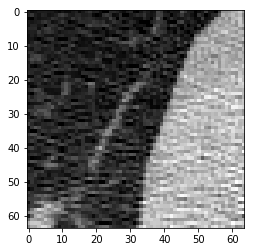

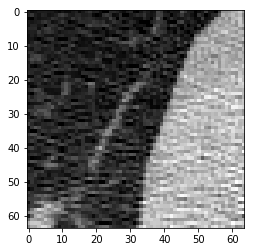

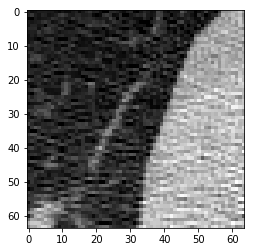

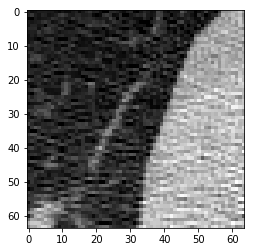

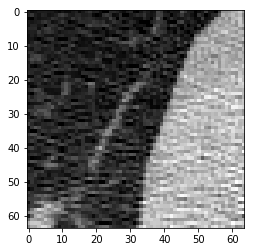

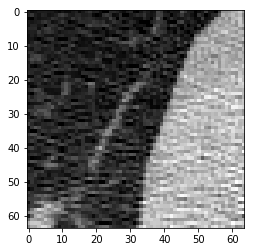

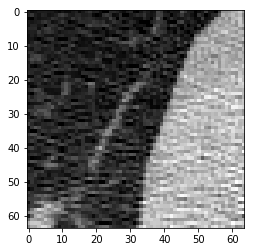

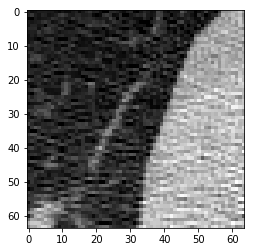

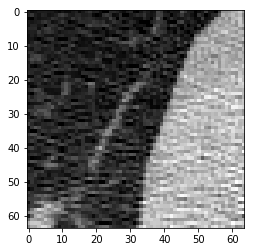

In [19]:
for cand in cands[1:10]:
    voxelWidth = 65
    x = int(voxelCoord[1])
    y = int(voxelCoord[2])
    z = int(voxelCoord[0])
    patch = numpyImage[z, x - voxelWidth // 2: x + voxelWidth // 2,
                       y - voxelWidth // 2: y + voxelWidth // 2]
    patch = normalizePlanes(patch)
    #print('patch nomalizes', patch)
    outputDir = 'patch/'
    plt.imshow(patch, cmap='gray')
    plt.show()
    # PIL Image, Creates an image memory from an object exporting the array interface (using the buffer protocol).
    # turn normalized pixel to range 0-255
    # convert to image file .png with color, 'L'- gray, 'RGB', 'CMYK'
    Image.fromarray(patch*255).convert('L').save(os.path.join(outputDir, img + '.png'))
    #print('patch*255', patch*255)